# Loop Hydrodynamic Simulations Example
In this notebook, we'll create a simulated active region, along with the loop components, and then simulate the evolution of these loops using EBTEL.

In [75]:
import os
import subprocess

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import astropy.units as u
from sunpy.net import vso

import synthesizAR
from synthesizAR.model_ext import UniformHeating,PowerLawScaledWaitingTimes,PowerLawUnscaledWaitingTimes
from synthesizAR.model_ext import EbtelInterface 

sns.set_context(context='notebook',font_scale=1.5)
%matplotlib inline

## Magnetic Skeleton
Query an HMI magnetogram, extrapolate the field, and trace the fieldlines.

First, get the HMI data.

In [2]:
#VSO not returning anything for some reason...
client = vso.VSOClient()
result_hmi = client.query(
     vso.attrs.Time((2013, 1, 1, 7, 34, 0), (2013, 1, 1, 9, 0, 0)),
     vso.attrs.Instrument('HMI'),
     vso.attrs.Physobs('LOS_magnetic_field'),   # Physical observables
     vso.attrs.Sample(5000 * u.s)
)
data_hmi = client.get(result_hmi,methods=('URL-FILE_Rice','URL-FILE')).wait()

Resample and crop the observation,

In [3]:
crop = (u.Quantity([-140,90]*u.arcsec),u.Quantity([420,560]*u.arcsec))
resample = u.Quantity([100,100]*u.pixel)

Create the skeleton,

In [4]:
field = synthesizAR.Skeleton(data_hmi[0],crop=crop,resample=resample)
zshape=50
zrange=u.Quantity([0.,150.]*u.arcsec)
field.extrapolate_field(zshape,zrange)

/opt/anaconda3/envs/synthesizar/lib/python3.5/site-packages/sunpy/image/transform.py:130: RuntimeWarning: Setting NaNs to 0 for higher-order scikit-image rotation
  RuntimeWarning)


True


/opt/anaconda3/envs/synthesizar/lib/python3.5/site-packages/numba/decorators.py:24: DeprecationWarning: autojit is deprecated, use jit instead which now performs the same functionality
  "the same functionality", DeprecationWarning)
yt : [INFO     ] 2016-10-12 13:55:37,645 Parameters: current_time              = 0.0
yt : [INFO     ] 2016-10-12 13:55:37,646 Parameters: domain_dimensions         = [96 96 46]
yt : [INFO     ] 2016-10-12 13:55:37,647 Parameters: domain_left_edge          = [ -9.60112377e+09   3.00297576e+10   4.25949509e+08]
yt : [INFO     ] 2016-10-12 13:55:37,648 Parameters: domain_right_edge         = [  6.06890905e+09   3.95486152e+10   1.02227882e+10]
yt : [INFO     ] 2016-10-12 13:55:37,650 Parameters: cosmological_simulation   = 0.0


Trace the fieldlines,

In [5]:
field.extract_streamlines(200)

yt : [INFO     ] 2016-10-12 13:55:37,985 AMRKDTree rebuilt, Final Volume: 1.461304e+30
Streamlining: 100%|██████████| 200/200 [00:00<00:00, 225.97it/s]
yt : [INFO     ] 2016-10-12 13:55:39,160 AMRKDTree rebuilt, Final Volume: 1.461304e+30
Streamlining: 100%|██████████| 102/102 [00:00<00:00, 242.57it/s]
yt : [INFO     ] 2016-10-12 13:55:39,812 AMRKDTree rebuilt, Final Volume: 1.461304e+30
Streamlining: 100%|██████████| 60/60 [00:00<00:00, 238.16it/s]
yt : [INFO     ] 2016-10-12 13:55:40,278 AMRKDTree rebuilt, Final Volume: 1.461304e+30
Streamlining: 100%|██████████| 27/27 [00:00<00:00, 230.28it/s]
yt : [INFO     ] 2016-10-12 13:55:40,590 AMRKDTree rebuilt, Final Volume: 1.461304e+30
Streamlining: 100%|██████████| 12/12 [00:00<00:00, 197.24it/s]
yt : [INFO     ] 2016-10-12 13:55:40,835 AMRKDTree rebuilt, Final Volume: 1.461304e+30
Streamlining: 100%|██████████| 6/6 [00:00<00:00, 164.92it/s]
yt : [INFO     ] 2016-10-12 13:55:41,054 AMRKDTree rebuilt, Final Volume: 1.461304e+30
Streamlinin

Take a quick look at the extrapolated field.

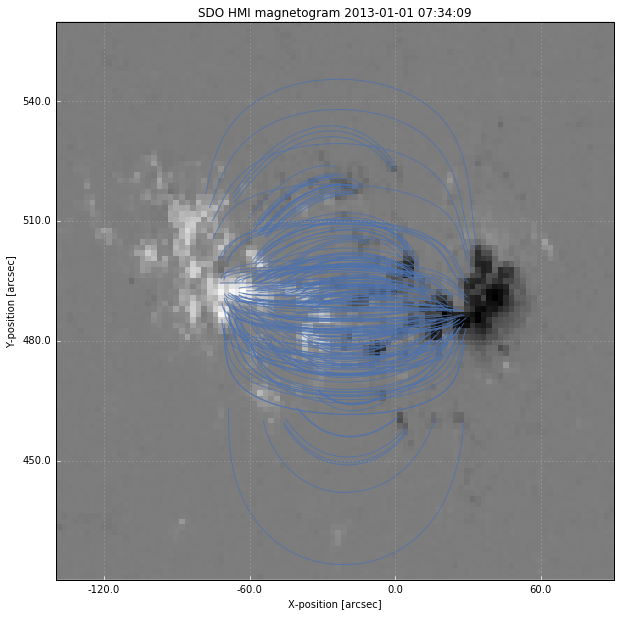

In [6]:
field.peek(alpha=0.75)

## Loops
Now, we'll use the individual streamlines as loops and compute the evolution of each with EBTEL. We can make 200 loop objects out of the streamlines by using,

In [29]:
field.make_loops()

Take a quick look at what the field-strength as a function of $s$ looks like.

(0, 1)

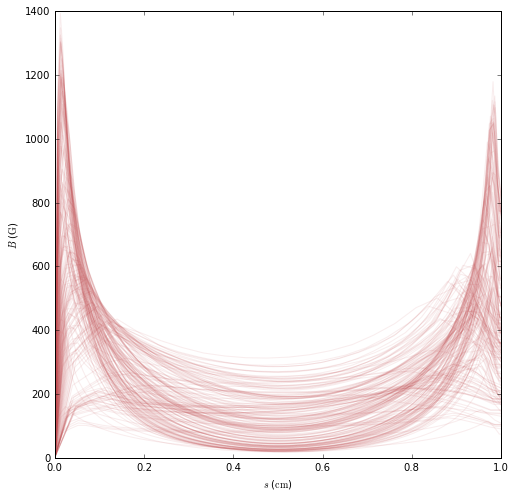

In [30]:
plt.figure(figsize=(8,8))
for loop in field.loops:
    plt.plot(loop.field_aligned_coordinate/loop.full_length,loop.field_strength,
             alpha=0.1,color=sns.color_palette('deep')[2])
plt.ylabel(r'$B$ ($\mathrm{{ {} }}$)'.format(loop.field_strength.unit.name))
plt.xlabel(r'$s$ ($\mathrm{{ {} }}$)'.format(loop.field_aligned_coordinate.unit.name))
plt.xlim([0,1])

Now, we want to configure an EBTEL run for each of these loop objects. But how will these loops be heated? To specify this, we configure a heating model object.

In [31]:
heating_options = {
    'duration':200.0,
    'duration_rise':50.0,
    'duration_decay':100.0,
    'average_waiting_time':1000.0,
    'stress_level':0.3,
    'alpha':-2.5,
    'delta_power_law_bounds':100,
    'waiting_time_scaling':1.0,
}
uni_model = UniformHeating(heating_options)
pl_model = PowerLawUnscaledWaitingTimes(heating_options)
pl_scaled_model = PowerLawScaledWaitingTimes(heating_options)

Now, load in a base dictionary (from the included example ebtel++ config file) for setting up all of the EBTEL parameters. When configuring the AR loops, we'll only need to alter a few parameters.

In [32]:
ih = synthesizAR.util.InputHandler(os.path.join(os.environ['RESEARCH_DIR'],'ebtelPlusPlus/config/ebtel.example.cfg.xml'))

In [33]:
base_config = ih.lookup_vars()

In [34]:
base_config['use_adaptive_solver'] = True
base_config['tau'] = 1.0
base_config['adaptive_solver_error'] = 1e-12
base_config['adaptive_solver_safety'] = 0.05
base_config['total_time'] = 25000.0

Next, instantiate the EBTEL interface for loading and configuring EBTEL input and output from and to the field object.

In [35]:
ebtel_plug = EbtelInterface(base_config,pl_scaled_model)

Finally, hand the EBTEL interface to the field and create the configuration files.

In [36]:
field.configure_loop_simulations(ebtel_plug,
                                 parent_config_dir='/data/datadrive2/ar_viz/test/config/',
                                 parent_results_dir='/data/datadrive2/ar_viz/test/results')

Power-law constrainer reached max # of tries, using best guess with error = 0.001027
Power-law constrainer reached max # of tries, using best guess with error = 0.001228
Power-law constrainer reached max # of tries, using best guess with error = 0.001167


And run the simulations,

In [37]:
for loop in field.loops:
    subprocess.call([os.path.join(os.environ['RESEARCH_DIR'],'ebtelPlusPlus/bin/ebtel++.run'),
                     '-c',loop.hydro_configuration['config_filename']])

And load the temperature and density profiles back into the loop.

In [38]:
field.load_loop_simulations(ebtel_plug)

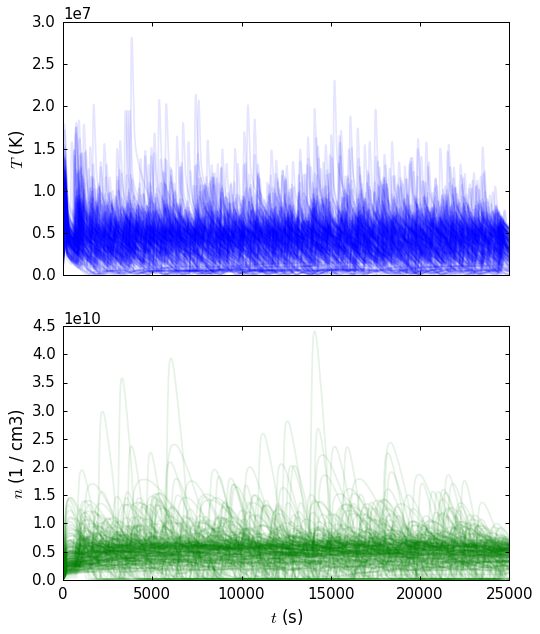

In [76]:
fig,ax = plt.subplots(2,1,figsize=(8,10),sharex=True)
for loop in field.loops:
    #ax[0].plot()
    ax[0].plot(loop.time,loop.temperature[:,0],color=sns.color_palette()[0],alpha=0.1)
    ax[1].plot(loop.time,loop.density[:,0],color=sns.color_palette()[1],alpha=0.1)
ax[1].set_xlabel(r'$t$ ({0})'.format(field.loops[0].time.unit.name))
ax[0].set_ylabel(r'$T$ ({0})'.format(field.loops[0].temperature.unit.name))
ax[1].set_ylabel(r'$n$ ({0})'.format(field.loops[0].density.unit))